In [22]:
#must run
import os
import cv2 as cv
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, BatchNormalization, MaxPooling2D, Dropout

In [23]:
#vital

#helper (used in dataset builer)
def class_name_maker(folder):
    try:
        start = folder.index("-")
        name = folder[start+1:]
        return name
    except ValueError:
        return folder

#helper (used for random sample inspect)
def random_sample(features, labels):
    index = np.random.randint(0, len(features))
    img = features[index]
    title = class_names[labels[index]]
    plt.imshow(img)
    plt.title(title)
    
#helper (used for loading saved dataset,  comes handy when working with big dataset)
def load_saved_dataset_files():
    path= '/kaggle/working/'
    train_features = np.load(path+'train_features_save.npy')
    test_features = np.load(path+'test_features_save.npy')
    train_labels = np.load(path+'train_labels_save.npy')
    test_labels = np.load(path+'test_labels_save.npy')
    class_names = np.load(path+'class_names_save.npy')
    print("File loading complete!")
    return train_features, test_features, train_labels, test_labels, class_names
#     except FileNotFoundError:
#         print("Failed to load files, no save file found")
#         return None

#helper (used  for saving train, test dataset, sequecce must be maintained)
def save_dataset_files(train_features, test_features, train_labels, test_labels, class_names):
    path= '/kaggle/working/'
    np.save(path+'train_features_save.npy', train_features)
    print("train_features_save.npy is saved\n")
    np.save(path+'test_features_save.npy', test_features)
    print("test_features_save.npy is saved\n")
    np.save(path+'train_labels_save.npy', train_labels)
    print("train_labels_save.npy is saved\n")
    np.save(path+'test_labels_save.npy', test_labels)
    print("test_labels_save.npy is saved\n")
    np.save(path+'class_names_save.npy', class_names)
    print("class_names_save.npy is saved\n")
    print('files saved at' + path)
    
#helper (used  for removing all the save files in the working directory)
def reset_project():
    path = '/kaggle/working/'
    saves = os.listdir(path)
    for file in saves:
        if ".npy" in file or  ".h5" in file:
            os.remove(path+file)
            print(str(file)+ " is removed")
    print("file removal complete!")

In [25]:
#vital (Prepairing data, loading from  the os file)
images = []
labels = []
class_names = []
size = (227, 227) # (We will build the alexNet cnn, so, to keep the math right, we are going with this size)
path = '/kaggle/input/stanford-dogs-dataset/images/Images'

#vital
def dataset_builder(path, num_classes):
    label=0
    breeds = os.listdir(path) 
    #incase  you have limited computitional power and you want to run the  test on a limited numbers of dog breed
    #-------------------------
    if num_classes>=120:
        breed_classes = breeds
    else:
        start = np.random.randint(0, (len(breeds)-num_classes), dtype = np.int32)
        breed_classes = breeds[start:start+num_classes]
    #-------------------------
    print("total number of breeds: "+ str(len(breed_classes)))
    
    for breed in breed_classes:
        path_to_breed = path + '/'+ breed
        files = os.listdir(path_to_breed)
        name = class_name_maker(breed)
        class_names.append(name)
        for file in files:
            path_to_image = path_to_breed+'/'+file
            img = cv.imread(path_to_image)
            if img is not None:
                img = cv.resize(img, dsize = size)
                images.append(img)
                labels.append(label)

        label+=1
        print(class_names[label-1] + ' = ' + str(label-1))
     

#only working with 30 breeds on this example 
dataset_builder(path, 30)

total number of breeds: 30
curly-coated_retriever = 0
beagle = 1
Tibetan_mastiff = 2
Sussex_spaniel = 3
Saint_Bernard = 4
toy_terrier = 5
standard_poodle = 6
Bernese_mountain_dog = 7
Pomeranian = 8
Ibizan_hound = 9
redbone = 10
toy_poodle = 11
basset = 12
Scottish_deerhound = 13
miniature_pinscher = 14
basenji = 15
Border_terrier = 16
Bedlington_terrier = 17
Kerry_blue_terrier = 18
Weimaraner = 19
English_setter = 20
bluetick = 21
Boston_bull = 22
Italian_greyhound = 23
Dandie_Dinmont = 24
Airedale = 25
Irish_water_spaniel = 26
Norfolk_terrier = 27
wire-haired_fox_terrier = 28
French_bulldog = 29


In [27]:
# Vital (Convertiong to an np array)
features = np.array(images).astype(np.float32)
labels = np.array(labels).astype(np.int32)
print("Converstion complete")

#vital (normalizing the features data)
features/=255
print("Normalization complete")

#vital (Spliting the data into test and train set)
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.2, random_state = 42, shuffle = True)
print("Split complete")

#vital (one hot encoding the labels)
train_labels =to_categorical(train_labels)
test_labels = to_categorical(test_labels)
print("One hot encoding completed")

Converstion complete
Normalization complete
Split complete
One hot encoding completed


In [ ]:
save_dataset_files(train_features, test_features, train_labels, test_labels, class_names)

(4226, 4226, 1057, 1057, 30)

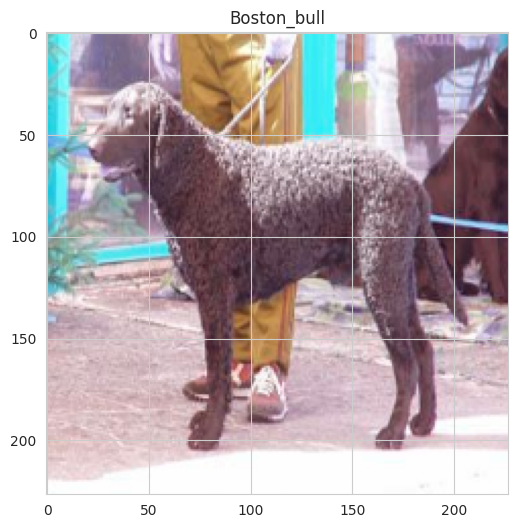

In [29]:
#visualization
len(images), len(labels), len(class_names)

#visualization
plt.imshow(images[320])
plt.title(class_names[labels[320]])

#visualization
random_sample(images, labels)

#visualization
features.dtype, labels.dtype
plt.imshow(features[23])

#visualization
plt.imshow(features[23])

#visualize
len(train_features), len(train_labels), len(test_features), len(test_labels), len(class_names)

Model Design
AlexNet architecture:

(CNN -> RN -> MP) 2 ---> (CNN 3 -> MP)-> (FC -> DO) * 2 -> Linear -> softmax

In [31]:
#model 1
def cnn_alex(input_size, num_of_classes):
    tf.random.set_seed(42)
    model = Sequential()
    #block one(initial block, first conv2d requires input_shape declairation)
    model.add(Conv2D(96, input_shape = input_size, kernel_size = (11,11), strides = (4,4), padding = 'same', activation = 'relu')),
    model.add(MaxPooling2D(pool_size=(3,3), strides = (2,2))),
    model.add(BatchNormalization()),


    #second block
    model.add(Conv2D(256, kernel_size = (5,5), strides =(1,1), padding = 'same', activation = 'relu')),
    model.add(MaxPooling2D(pool_size=(3,3), strides = (2,2))),
    model.add(BatchNormalization()),

    #third block
    model.add(Conv2D(384, kernel_size = (3,3), strides = (1,1), padding = 'same', activation = 'relu')),
    model.add(Conv2D(384, kernel_size = (3,3), strides = (1,1), padding = 'same', activation = 'relu')),
    model.add(Conv2D(256, kernel_size = (3,3), strides = (1,1), padding = 'same', activation = 'relu')),
    model.add(MaxPooling2D(pool_size=(3,3), strides = (2,2))),
    model.add(BatchNormalization()),

    
    model.add(Flatten()),
    
    #FC layers
    model.add(Dense(4096, activation ='relu')),
    model.add(Dropout(0.5)),
#     model.add(BatchNormalization()),

    model.add(Dense(4096, activation = 'relu')),
    model.add(Dropout(0.5)),
#     model.add(BatchNormalization()),

    model.add(Dense(num_of_classes, activation = 'softmax'))
    
    
    model.compile(
        loss = tf.keras.losses.CategoricalCrossentropy(),
        optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001),
        metrics = ['accuracy']
    )
    return model

Create an instance of your mode

In [32]:
#vital (creates an instance of the model)
model_alex = cnn_alex(train_features[0].shape, len(class_names))
print("Model initiated")
model_alex.summary()

Model initiated
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 57, 57, 96)        34944     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 28, 28, 96)        0         
 g2D)                                                            
                                                                 
 batch_normalization (Batch  (None, 28, 28, 96)        384       
 Normalization)                                                  
                                                                 
 conv2d_7 (Conv2D)           (None, 28, 28, 256)       614656    
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 13, 13, 256)       0         
 g2D)                                                            
                                        

Training

In [ ]:
#vital (Starts the training process)
history_alex = model_alex.fit(train_features, train_labels, epochs = 50)

Epoch 1/50
  3/133 [..............................] - ETA: 6:34 - loss: 2.3223 - accuracy: 0.3646

In [ ]:
#vital
model_alex.save('/kaggle/working/model_alex_save.h5')
model_alex.evaluate(test_features, test_labels)

In [ ]:
#visualization
pd.DataFrame(history_alex.history).plot()

Epoch 1/5
  1/515 [..............................] - ETA: 23:10:41 - loss: 18.4328 - accuracy: 0.0000e+00